In [52]:
import torch, os, math
from math import sqrt
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import lightning as pl

from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision.datasets import MNIST

from modules.trainers.DDPM import DDPM

In [53]:
tf = transforms.Compose([transforms.ToTensor()])
data = MNIST("/media/volume/sdb/data", train=False, download=False, transform=tf)
print(len(data))
print(data[0][0].shape)
images, labels = zip(*[data[i] for i in range(32)])
images = np.array(images)
print(images.shape)

10000
torch.Size([1, 28, 28])
(32, 1, 28, 28)


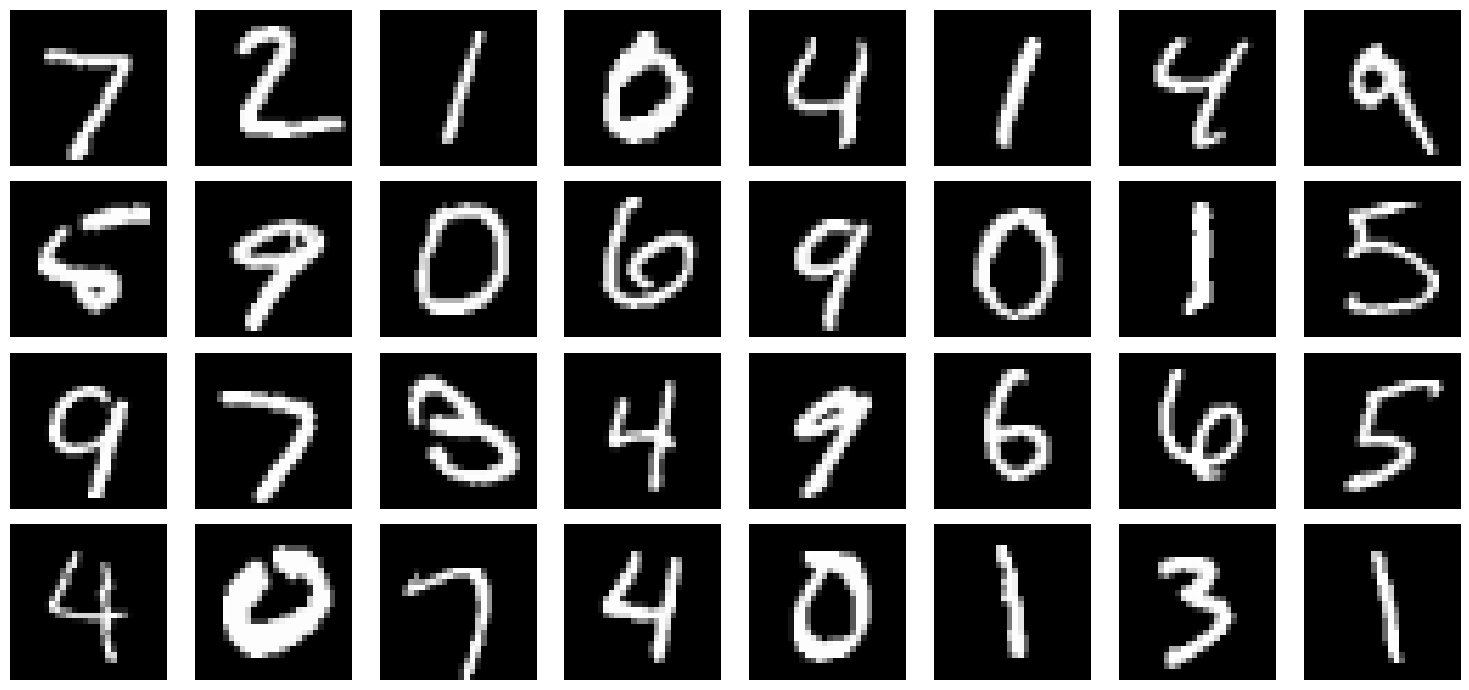

In [54]:
# Set up the plot
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range(32):
    # Display image
    axes[i].imshow(images[i].squeeze(), cmap='gray')

    # Remove axis ticks
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [55]:
# load a pretrained model and send to device for examples below
model = DDPM.load_from_checkpoint('./genmod/5o2hn164/checkpoints/last.ckpt')
model.eval()

device = "cuda:0"

model = model.to(device)

# Forward Diffusion Process

In [56]:
images = torch.Tensor(images).to(device)
# randomly select timesteps along diffusion trajectory
timesteps = torch.randint(1, model.n_T, (images.shape[0],)).long().to(device)  # t ~ Uniform(0, n_T=1000)
# randomly sample noise N(0,I), remember this is our target value - the nn is optimized to reconstruct this!
noise = torch.randn_like(images)
# using the randomly sampled noise diffuse our minibatch of images to each timestep sampled above
x_t = model.forward_diffusion_process(images, timesteps, noise)
# lets get some predictions from the network to show that it is actually predicting the noise, not the image
noise_hat = model.nn_model(x_t, timesteps / model.n_T)

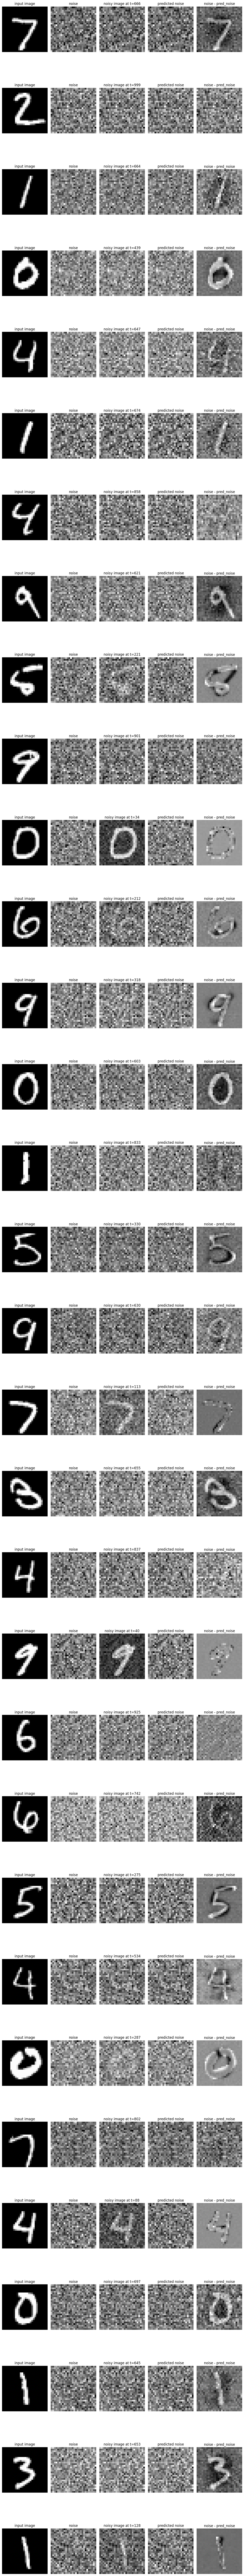

In [59]:
# Set up the plot
fig, axes = plt.subplots(nrows=32, ncols=5, figsize=(3*4, 32*4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

j = 0
for i in range(32):
    # Display image
    axes[j].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
    axes[j+1].imshow(noise[i].cpu().numpy().squeeze(), cmap='gray')
    axes[j+2].imshow(x_t[i].cpu().numpy().squeeze(), cmap='gray')
    axes[j+3].imshow(noise_hat[i].detach().cpu().numpy().squeeze(), cmap='gray')
    axes[j+4].imshow(noise_hat[i].detach().cpu().numpy().squeeze() - noise[i].cpu().numpy().squeeze(), cmap='gray')

    # Remove axis ticks
    axes[j].axis('off')
    axes[j].set_title('input image')
    axes[j+1].axis('off')
    axes[j+1].set_title('noise')
    axes[j+2].set_title(f'noisy image at t={timesteps[i]}')
    axes[j+2].axis('off')
    axes[j+3].set_title(f'predicted noise')
    axes[j+3].axis('off')
    axes[j+4].set_title(f'noise - pred_noise')
    axes[j+4].axis('off')
    
    j += 5

# Adjust layout
plt.tight_layout()
plt.show()

# Reverse Diffusion Process

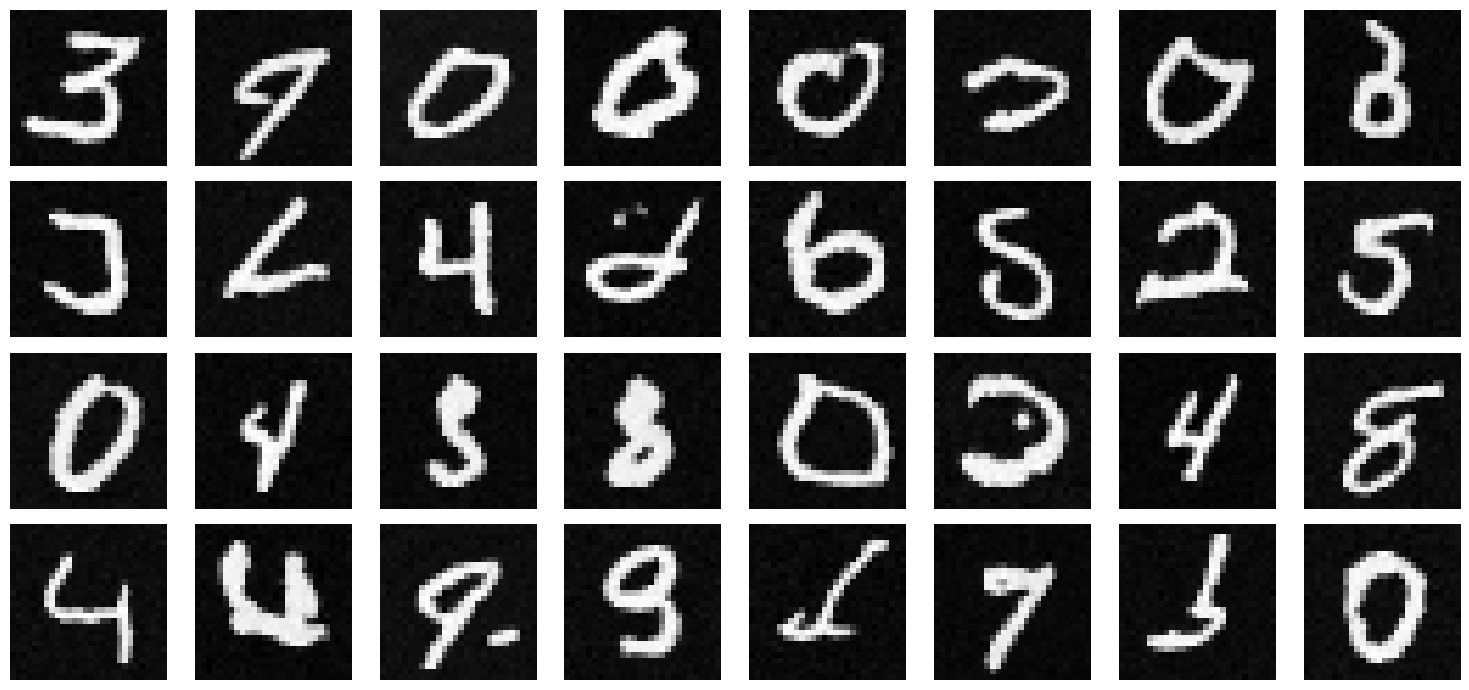

In [61]:
gen_imgs = []
with torch.no_grad():
    x_i = torch.randn((32,1,28,28)).to(device)  # x_T ~ N(0, 1), sample initial noise
    x_0 = model.reverse_diffusion_process(x_i)

gen_imgs.append(x_0.detach().cpu().numpy())
gen_imgs = rearrange(gen_imgs, '1 b c h w -> b c h w')

# Set up the plot
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range(32):
    # Display image
    axes[i].imshow(gen_imgs[i].squeeze(), cmap='gray')

    # Remove axis ticks
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()